In [ ]:
from math import sqrt
import numpy as np
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from keras.layers import Bidirectional
import datetime
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import array
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
series = []
with open("lorenz.txt", 'r') as f:
  lines = f.readlines()
  for line in lines:
    series.append(float(line))

const_len = 150
scv_series = []
for i in range(len(series) - const_len):
  scv_series.append(series[i:i+const_len])

scv_series = pd.DataFrame(scv_series, columns=np.arange(const_len))
scv_series.to_csv("lorenz.csv", header=True)

In [ ]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [ ]:
def MODEL_CNN(x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])
    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps_in,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(Hidden, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    print(model.summary())
    Best_RMSE=1000   #Assigning a large number 
    
    start_time=time.time()
    for run in range(Num_Exp):
        print("Experiment",run+1,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        if test_acc[run]<Best_RMSE:
            Best_RMSE=test_acc[run]
            Best_Predict_Test=y_predicttest
        for j in range(n_steps_out):
            Step_RMSE[run][j]=rmse(y_predicttest[:,j], y_test[:,j])
            
    print("Total time for",Num_Exp,"experiments",time.time()-start_time)
    return train_acc, test_acc, Step_RMSE, Best_Predict_Test

def MODEL_LSTM(x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])
    
    model = Sequential()
    model.add(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True))
    model.add(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    Best_RMSE=1000   #Assigning a large number 
    
    start_time=time.time()
    for run in range(Num_Exp):
        print("Experiment",run+1,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        if test_acc[run]<Best_RMSE:
            Best_RMSE=test_acc[run]
            Best_Predict_Test=y_predicttest
        for j in range(n_steps_out):
            Step_RMSE[run][j]=rmse(y_predicttest[:,j], y_test[:,j])
            
    print("Total time for",Num_Exp,"experiments",time.time()-start_time)
    return train_acc,test_acc,Step_RMSE,Best_Predict_Test


def MODEL_Bi_LSTM(x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs,Hidden):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])
    
    model = Sequential()
    model.add(Bidirectional(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True),
                            input_shape=(n_steps_in, n_features)))
    model.add(Bidirectional(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True)))
    model.add(Bidirectional(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid')))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    Best_RMSE=1000   #Assigning a large number 
    Best_Predict_Test = 0
    start_time=time.time()
    for run in range(Num_Exp):
        print("Experiment",run+1,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        if test_acc[run]<Best_RMSE:
            Best_RMSE=test_acc[run]
            Best_Predict_Test=y_predicttest
        for j in range(n_steps_out):
            Step_RMSE[run][j]=rmse(y_predicttest[:,j], y_test[:,j])
            
    print("Total time for",Num_Exp,"experiments",time.time()-start_time)
    print(train_acc, test_acc, Step_RMSE, Best_Predict_Test)
    return model,train_acc,test_acc,Step_RMSE,Best_Predict_Test


def MODEL_EN_DC(x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs,Hidden):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
    print(y_train.shape)
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
    print(y_test.shape)
    
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])
    
    model = Sequential()
    model.add(LSTM(Hidden, activation='relu',input_shape=(n_steps_in,n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(Hidden, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1,activation='relu')))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    Best_RMSE=1000   #Assigning a large number 
    start_time=time.time()
    for run in range(Num_Exp):
        print("Experiment",run+1,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        if test_acc[run]<Best_RMSE:
            Best_RMSE=test_acc[run]
            Best_Predict_Test=y_predicttest
        for j in range(n_steps_out):
            Step_RMSE[run][j]=rmse(y_predicttest[:,j,0], y_test[:,j,0])
            
    print("Total time for",Num_Exp,"experiments",time.time()-start_time)
    return train_acc,test_acc,Step_RMSE,Best_Predict_Test.reshape(y_test.shape[0], y_test.shape[1])



In [ ]:
def main():

    n_steps_in, n_steps_out = 4, 5
    for i in range(1):
        problem=4
        if problem == 4:
            TrainData = pd.read_csv("lorenz.csv", index_col = 0)
            TrainData = TrainData.values
            TrainData = TrainData[:8200]
            TestData = pd.read_csv("lorenz.csv",index_col = 0)
            TestData = TestData.values
            TestData = TestData[8200:8700] 
            name= "Lorenz"

        x_train = TrainData[:,0:n_steps_in]
        y_train = TrainData[:,n_steps_in : n_steps_in+n_steps_out ]
        x_test = TestData[:,0:n_steps_in]
        y_test = TestData[:,n_steps_in : n_steps_in+n_steps_out]

        print(name)
        Num_Exp = 3    #No. of experiments
        Epochs = 1000
        Hidden = 3
        train_acc=np.zeros(Num_Exp)
        test_acc=np.zeros(Num_Exp)
        Step_RMSE=np.zeros([Num_Exp,n_steps_out])

        for method in range(4):
            if method == 0:
                train_acc, test_acc, Step_RMSE, Best_Predict_Test = MODEL_CNN(x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden)
                Mname="MODEL_CNN"
            if method == 1:
                train_acc, test_acc, Step_RMSE, Best_Predict_Test = MODEL_LSTM(x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden)
                Mname="MODEL_LSTM"
            if method == 2:
                model, train_acc, test_acc, Step_RMSE, Best_Predict_Test = MODEL_Bi_LSTM(x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs,Hidden)
                Mname="MODEL_Bi_LSTM"
            if method == 3:
                train_acc, test_acc, Step_RMSE, Best_Predict_Test = MODEL_EN_DC(x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs,Hidden)
                Mname="MODEL_EN_DC"

            print(Mname)

            arr = np.dstack((train_acc,test_acc))
            arr=arr.reshape(Num_Exp,2)
            arr=np.concatenate((arr,Step_RMSE), axis=1)
            arr=arr.reshape(Num_Exp,2+n_steps_out)

            ExpIndex=np.array([])
            for j in range(Num_Exp):
                ExpIndex=np.concatenate((ExpIndex,["Exp"+str(j+1)]))

            ExpIndex1=['TrainRMSE','TestRMSE']
            for j in range(n_steps_out):
                ExpIndex1=np.concatenate((ExpIndex1,["Step"+str(j+1)]))

            arr=np.round_(arr, decimals = 5) 
            arr = pd.DataFrame(arr, index = ExpIndex , columns = ExpIndex1)

            Train_Mean=np.mean(train_acc)
            Train_Std=np.std(train_acc)
            Train_CI_LB= Train_Mean-1.96*(Train_Std/np.sqrt(Num_Exp))
            Train_CI_UB= Train_Mean+1.96*(Train_Std/np.sqrt(Num_Exp))

            Test_Mean=np.mean(test_acc)
            Test_Std=np.std(test_acc)
            Test_CI_LB= Test_Mean-1.96*(Test_Std/np.sqrt(Num_Exp))
            Test_CI_UB= Test_Mean+1.96*(Test_Std/np.sqrt(Num_Exp))

            arr1 = np.vstack(([Train_Mean,Train_Std,Train_CI_LB,Train_CI_UB,np.min(train_acc),np.max(train_acc)],[Test_Mean,Test_Std,Test_CI_LB,Test_CI_UB,np.min(test_acc),np.max(test_acc)]))

            for j in range(n_steps_out):
                Step_mean = np.mean(Step_RMSE[:,j])
                Step_std = np.std(Step_RMSE[:,j])
                Step_min = np.min(Step_RMSE[:,j])
                Step_CI_LB= Step_mean-1.96*(Step_std/np.sqrt(Num_Exp))
                Step_CI_UB= Step_mean+1.96*(Step_std/np.sqrt(Num_Exp))
                arr1=np.vstack((arr1,[Step_mean,Step_std,Step_CI_LB,Step_CI_UB,Step_min,np.max(Step_RMSE[:,j])]))
            arr1=np.round_(arr1, decimals = 5) 
            arr1 = pd.DataFrame(arr1, index=ExpIndex1, columns = ['Mean','Standard Deviation','CI_LB','CI_UB','Min','Max'])
            print(arr1)


            x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
            for j in range(n_steps_out):
                plt.figure()
                plt.plot(x_data, y_test[:,j], label='actual')
                plt.plot(x_data, Best_Predict_Test[:,j], label='predicted')
                plt.ylabel('RMSE')  
                plt.xlabel('Time (samples)') 
                plt.title('Actual vs Predicted')
                plt.legend()
                plt.show()
                plt.close()
#     return model

Lorenz
(9200, 4, 1)
(500, 4, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 4, 8)              192       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 8)              416       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 5)                 45        
Total params: 1,069
Trainable params: 1,069
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
Total time for 1 experiments 1184.5411157608032
[0.02775956] [0.02769029] [[0.00638214 0.01024851 0.01006159 0.01516525 0.01702257]] [[0.48577243 0.44265217 0.39428645 0.2822707  0.15836334]
 [0.

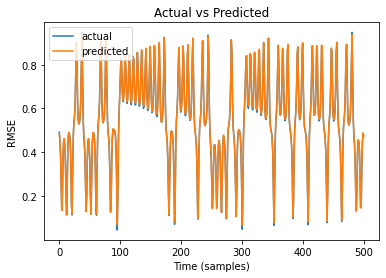

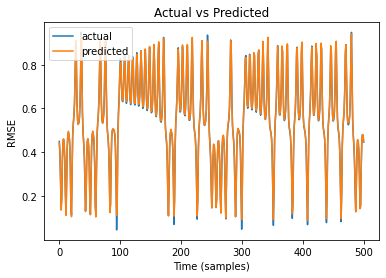

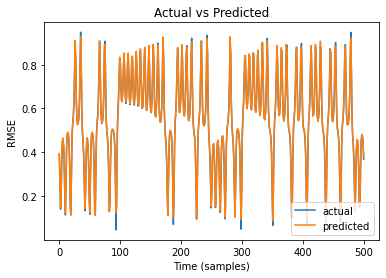

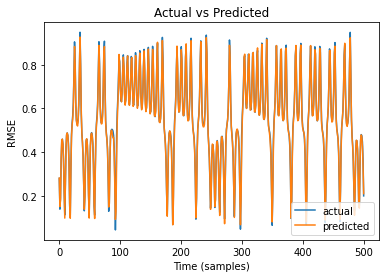

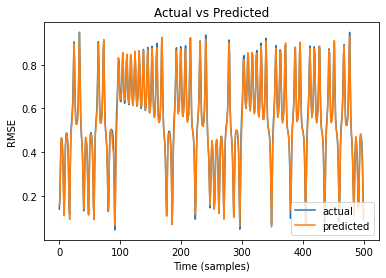

In [ ]:
#!g1.1
model = main()

In [ ]:
# import keras
# import os

def train_final(template, model_name, method = 0):
    TrainData = pd.read_csv("lorenz.csv", index_col = 0)
    TrainData = TrainData.values
    TrainData = np.array(TrainData[:5000])
    TestData = pd.read_csv("lorenz.csv", index_col = 0)
    TestData = TestData.values
    TestData = np.array(TestData[5200:5700])
    n_steps_in = 3
    n_steps_out = 5
    x_train = TrainData[:, template[:-1]]
    y_train = TrainData[:, template[-1]: template[-1] + n_steps_out]
    x_test = TestData[:, template[:-1]]
    y_test = TestData[:, template[-1]: template[-1] + n_steps_out]
    name= "Lorenz"

    print(name)
    Num_Exp=1    #No. of experiments
    Epochs=150
    Hidden=3
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])

    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])
    
    model = Sequential()
    if method == 0:
      fine_model.add(Bidirectional(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True), input_shape=(n_steps_in, n_features)))
      fine_model.add(Bidirectional(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True)))
      fine_model.add(Bidirectional(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid')))
      fine_model.add(Dense(n_steps_out))
      fine_model.compile(optimizer='adam', loss='mse')
      fine_model.summary()
    elif method == 1:
      model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps_in,n_features)))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Flatten())
      model.add(Dense(Hidden, activation='relu'))
      model.add(Dense(n_steps_out))
      model.compile(optimizer='adam', loss='mse')
    elif method == 2:
      model.add(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True, input_shape=(n_steps_in, n_features)))
      model.add(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid', return_sequences=True))
      model.add(LSTM(Hidden, activation='tanh', recurrent_activation = 'sigmoid'))
      model.add(Dense(n_steps_out))
      model.compile(optimizer='adam', loss='mse')
      model.summary()

    
    Best_RMSE=1000   #Assigning a large number 
    Best_Predict_Test = 0
    start_time=time.time()
    for run in range(Num_Exp):
        print("Experiment",run+1,"in progress")
        # fit model
        fine_model.fit(x_train, y_train, epochs=Epochs, batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = fine_model.predict(x_train)
        y_predicttest = fine_model.predict(x_test)
        train_acc[run] = rmse(y_predicttrain,y_train) 
        test_acc[run] = rmse(y_predicttest, y_test) 
        if test_acc[run] < Best_RMSE:
            Best_RMSE=test_acc[run]
            Best_Predict_Test=y_predicttest
        for j in range(n_steps_out):
            Step_RMSE[run][j]=rmse(y_predicttest[:,j], y_test[:,j])
            
    print("Total time for", Num_Exp, "experiments", time.time()-start_time)
    print(train_acc, test_acc, Step_RMSE, Best_Predict_Test)

    arr = np.dstack((train_acc,test_acc))
    arr=arr.reshape(Num_Exp,2)
    arr=np.concatenate((arr,Step_RMSE), axis=1)
    arr=arr.reshape(Num_Exp,2+n_steps_out)

    ExpIndex=np.array([])
    for j in range(Num_Exp):
        ExpIndex=np.concatenate((ExpIndex,["Exp"+str(j+1)]))

    ExpIndex1=['TrainRMSE','TestRMSE']
    for j in range(n_steps_out):
        ExpIndex1=np.concatenate((ExpIndex1,["Step"+str(j+1)]))

    arr=np.round_(arr, decimals = 5) 
    arr = pd.DataFrame(arr, index = ExpIndex , columns = ExpIndex1)
    # arr.to_csv("Results/"+name+"/"+Mname+"/ExpAnalysis.csv")
    # print(arr)

    Train_Mean=np.mean(train_acc)
    Train_Std=np.std(train_acc)
    Train_CI_LB= Train_Mean-1.96*(Train_Std/np.sqrt(Num_Exp))
    Train_CI_UB= Train_Mean+1.96*(Train_Std/np.sqrt(Num_Exp))

    Test_Mean=np.mean(test_acc)
    Test_Std=np.std(test_acc)
    Test_CI_LB= Test_Mean-1.96*(Test_Std/np.sqrt(Num_Exp))
    Test_CI_UB= Test_Mean+1.96*(Test_Std/np.sqrt(Num_Exp))

    arr1 = np.vstack(([Train_Mean,Train_Std,Train_CI_LB,Train_CI_UB,np.min(train_acc),np.max(train_acc)],[Test_Mean,Test_Std,Test_CI_LB,Test_CI_UB,np.min(test_acc),np.max(test_acc)]))

    for j in range(n_steps_out):
        Step_mean = np.mean(Step_RMSE[:,j])
        Step_std = np.std(Step_RMSE[:,j])
        Step_min = np.min(Step_RMSE[:,j])
        Step_CI_LB= Step_mean-1.96*(Step_std/np.sqrt(Num_Exp))
        Step_CI_UB= Step_mean+1.96*(Step_std/np.sqrt(Num_Exp))
        arr1=np.vstack((arr1,[Step_mean,Step_std,Step_CI_LB,Step_CI_UB,Step_min,np.max(Step_RMSE[:,j])]))
    arr1=np.round_(arr1, decimals = 5) 
    arr1 = pd.DataFrame(arr1, index=ExpIndex1, columns = ['Mean','Standard Deviation','CI_LB','CI_UB','Min','Max'])


    x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
    fine_model.save(f'weights_final_{method}' + '/model_' + model_name)
    return fine_model

**Нормальное применение шаблонов**

In [ ]:
#!g1.1

max_template_spread = 8
points_in_template = 4
x_dim: int = max_template_spread ** (points_in_template - 1)  # сколько у нас всего шаблонов
z_dim: int = points_in_template                               # сколько зубчиков в каждом шаблоне

# сами шаблоны
templates = (np.repeat(0, x_dim).reshape(-1, 1), )

for i in range(1, points_in_template):
    col = (np.repeat(
        np.arange(1, max_template_spread + 1, dtype=int), max_template_spread ** (points_in_template - (i + 1))
    ) + templates[i - 1][::max_template_spread ** (points_in_template - i)]).reshape(-1, 1)

    templates += (col, ) 

templates: np.ndarray = np.hstack(templates)

# формы шаблонов, т.е. [1, 1, 1], [1, 1, 2] и т.д.
template_shapes: np.ndarray = templates[:, 1:] - templates[:, :-1]
    
# распараллеливание обучения
n_patterns = len(templates):
for i in range(n_patterns):
    train_final(templates[i], "_".join([str(j) for j in templates[i]]))
# n_patterns = 2
# models = Parallel(n_jobs=-1)(delayed(train_final)(templates[i], "_".join([str(j) for j in templates[i]])) for i in range(n_patterns))

In [ ]:
#!g1.1
for i in range(1):
    train_final([1, 1, 1], f"new_{i}")

Lorenz
(9200, 70, 1)
(500, 70, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 70, 100)           20800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 100)           60400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 100)           60400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
Total params: 205,030
Trainable params: 205,030
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
Total time for 1 experiments 494.0524604320526
[0.1687606

INFO:tensorflow:Assets written to: weights/modelnew_0/assets


In [ ]:
#!c1.4
TestData = pd.read_csv("lorenz.csv",index_col = 0)
TestData = TestData.values
TestData = TestData[7000:9300]
y_test = TestData[:, n_steps_in: n_steps_in + n_steps_out + 30]


n_steps_in, n_steps_out = 70, 30
number_of_models = 70
n = 30
prevs_fine = [0] * number_of_models
prevs = []


for i in range(n):
    if i % 5 == 0:
        print("i", i)
    if len(prevs) != 0:
        x_test = np.concatenate((TestData[:,1 + i : n_steps_in + 1], prevs), axis = 1)
    else:
        x_test = TestData[:,1 + i : n_steps_in + 1]
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    y_predicttest = model.predict(x_test)
    if len(prevs) == 0:
        prevs = y_predicttest[:, 0]
        prevs = prevs.reshape((prevs.shape[0], 1))
    else:
        prevs = np.concatenate((prevs, y_predicttest[:, 0].reshape(y_predicttest[:, 0].shape[0], 1)), axis = 1)
for j in range(number_of_models):
    if j % 5 == 0:
        print("j", j)
    fine_model = keras.models.load_model('weights/model_new_' + f"{j}")
    for i in range(n):
        if i != 0:
            x_test = np.concatenate((TestData[:,0 : n_steps_in + 1], prevs_fine[j]), axis = 1)
        else:
            x_test = TestData[:,0: n_steps_in + 1]

        x_test = x_test[:, -n_steps_in - 1:]
        x_test = np.concatenate((x_test[:,0:j], x_test[:,j + 1:n_steps_in + 1]), axis=1)
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        y_predicttest = fine_model.predict(x_test)
        if i == 0:
            prevs_fine[j] = y_predicttest[:, 0]
            prevs_fine[j] = prevs_fine[j].reshape((prevs_fine[j].shape[0], 1))
        else:
            prevs_fine[j] = np.concatenate((prevs_fine[j], y_predicttest[:, 0].reshape(y_predicttest[:, 0].shape[0], 1)), axis = 1)

i 0
i 5
i 10
i 15
i 20
i 25
j 0
j 5
j 10
j 15
j 20
j 25
j 30
j 35
j 40
j 45
j 50
j 55
j 60
j 65


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: model
  warnings.warn(message)


In [ ]:
with open('prevs_fine.npy', 'wb') as f:
    np.save(f, np.array(prevs_fine))

In [ ]:
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
prevs_fine = np.array(prevs_fine)

In [ ]:
x_regressor = []
for j in range(prevs_fine.shape[1]):
    for k in range(prevs_fine.shape[2]):
        x_regressor.append(prevs_fine[:, j, k])
x_regressor = np.array(x_regressor)
x_regressor = np.round(x_regressor, 2)
x_regressor_freq = []
for i in range(x_regressor.shape[0]):
    values, counts = np.unique(x_regressor[i, :], return_counts=True)
    values = (values * 100).astype(np.int64)
    x_regressor_freq.append(np.zeros(101))
    for i, val in enumerate(values):
        if val <= 100:
            x_regressor_freq[-1][val] = counts[i]
        else:
            x_regressor_freq[-1][100] = counts[i]
x_regressor_freq = np.array(x_regressor_freq)

In [ ]:
y_regressor = TestData[:, n_steps_in + 1: n_steps_in + n_steps_out + 30 + 1]
y_regressor = y_regressor[:, :n]
y_regressor = y_regressor.reshape((1, -1))
y_regressor = y_regressor[0]
y_regressor = np.round(y_regressor, 2)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_regressor_freq, y_regressor, test_size=0.2)

In [ ]:
from catboost import CatBoostRegressor
regressor = CatBoostRegressor()
regressor.fit(x_train, y_train, eval_set = (x_test, y_test))

In [ ]:
regressor.save_model("catboost_regressor")

In [ ]:
y_predicted = regressor.predict(x_regressor_freq)
y_class = abs(y_predicted - y_regressor) < 0.03
y_class = y_class.astype(np.int)

In [ ]:
y_class[y_class == 1].sum()

29472

In [ ]:
new_x = np.concatenate((x_regressor_freq, y_predicted.reshape(-1, 1)), axis = 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_x, y_class, test_size=0.3)

In [ ]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(use_best_model=True, iterations=5000)
classifier.fit(x_train, y_train, eval_set = (x_test, y_test))

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = classifier.predict(x_test)
print(y_pred)
accuracy_score(y_pred, y_test)

[1 1 0 ... 1 0 0]


0.7763768115942029

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_pred = classifier.predict_proba(x_test)
y_pred = y_pred[:, 1]
roc_auc_score(y_test, y_pred)

0.8471944711826414

In [ ]:
classifier.save_model("catboost_classifier")

In [ ]:
max_template_spread = 8
points_in_template = 4
x_dim: int = max_template_spread ** (points_in_template - 1)  # сколько у нас всего шаблонов
z_dim: int = points_in_template                               # сколько зубчиков в каждом шаблоне

# сами шаблоны
templates = (np.repeat(0, x_dim).reshape(-1, 1), )

for i in range(1, points_in_template):
    col = (np.repeat(
        np.arange(1, max_template_spread + 1, dtype=int), max_template_spread ** (points_in_template - (i + 1))
    ) + templates[i - 1][::max_template_spread ** (points_in_template - i)]).reshape(-1, 1)

    templates += (col, ) 

templates: np.ndarray = np.hstack(templates)

# формы шаблонов, т.е. [1, 1, 1], [1, 1, 2] и т.д.
template_shapes: np.ndarray = templates[:, 1:] - templates[:, :-1]
vectors = np.cumsum(-template_shapes[:, ::-1], axis=1)[:, ::-1]

TestData = pd.read_csv("lorenz.csv",index_col = 0)
TestData = TestData.values
TestData = TestData[9300:9550]

n_steps_in, n_steps_out = 70, 30
number_of_models = len(templates) // 2
# number_of_models = 2
n = 100
prevs_fine = [0] * number_of_models
prevs = []
predicted_values = []
final_prevs = []
final_predictable = []

method = 0

for i in tqdm(range(n)):
    for j in range(number_of_models):
        fine_model = keras.models.load_model(f'weights_final/model_' + "_".join([str(k) for k in templates[j]]))
        if i != 0:
            x_test = np.concatenate((TestData[:, :32], final_prevs), axis = 1)
        else:
            x_test = TestData[:, :32]
        x_test = x_test[:, vectors[j]]
        nan_mask  = np.isnan(x_test).any(axis=1)
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        y_predicttest = fine_model.predict(x_test)
        prevs_fine[j] = y_predicttest[:, 0].reshape(y_predicttest.shape[0], 1)
        prevs_fine[j][nan_mask] = np.nan
        # prevs_fine[j] = prevs_fine[j].reshape((prevs_fine[j].shape[0], 1))
        
    prevs_fine = np.array(prevs_fine)
    x_regressor = []
    for j in range(prevs_fine.shape[1]):
        for k in range(prevs_fine.shape[2]):
            x_regressor.append(prevs_fine[:, j, k])
    x_regressor = np.array(x_regressor)
    x_regressor = np.round(x_regressor, 2)
    x_regressor_freq = []
    for k in range(x_regressor.shape[0]):
        values, counts = np.unique(x_regressor[k, :], return_counts=True)
        values = (values * 100).astype(np.int64)
        x_regressor_freq.append(np.zeros(101))
        for f, val in enumerate(values):
            if val <=100 and val >= 0:
                x_regressor_freq[-1][val] = counts[f]
            elif val >= 100 and val < 150:
                x_regressor_freq[-1][100] = counts[f]
    x_regressor_freq = np.array(x_regressor_freq)
    predicted_values = regressor.predict(x_regressor_freq)
    new_x = np.concatenate((x_regressor_freq, predicted_values.reshape(-1, 1)), axis = 1)
    is_predictable = classifier.predict(new_x)
    # predicted_values[is_predictable == 0] = np.nan
    predicted_values = predicted_values.reshape((predicted_values.shape[0], 1))
    is_predictable = is_predictable.reshape((is_predictable.shape[0], 1))
    if i == 0:
        final_prevs = predicted_values
        final_predictable = is_predictable
    else:
        final_prevs = np.concatenate((final_prevs, predicted_values), axis = 1)
        final_predictable = np.concatenate((final_predictable, is_predictable), axis = 1)

100%|██████████| 5/5 [5:00:47<00:00, 3609.44s/it]


In [ ]:
#!g1.1
TestData = pd.read_csv("lorenz.csv",index_col = 0)
TestData = TestData.values
TestData = TestData[9300:9500]
y_test = TestData[:, n_steps_in: n_steps_in + n_steps_out + 30]


n_steps_in, n_steps_out = 70, 30
number_of_models = 70
n = 30
prevs_fine = [0] * number_of_models
prevs = []

model  = keras.models.load_model('base_model_9000')
    
for i in range(n):
    if i % 5 == 0:
        print("i", i)
    if len(prevs) != 0:
        x_test = np.concatenate((TestData[:,1 + i : n_steps_in + 1], prevs), axis = 1)
    else:
        x_test = TestData[:,1 + i : n_steps_in + 1]
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    y_predicttest = model.predict(x_test)
    if len(prevs) == 0:
        prevs = y_predicttest[:, 0]
        prevs = prevs.reshape((prevs.shape[0], 1))
    else:
        prevs = np.concatenate((prevs, y_predicttest[:, 0].reshape(y_predicttest[:, 0].shape[0], 1)), axis = 1)
for j in range(number_of_models):
    if j % 5 == 0:
        print("j", j)
    fine_model = keras.models.load_model('weights/model_new_' + f"{j}")
    for i in range(n):
        if i != 0:
            x_test = np.concatenate((TestData[:,0 : n_steps_in + 1], prevs_fine[j]), axis = 1)
        else:
            x_test = TestData[:,0: n_steps_in + 1]

        x_test = x_test[:, -n_steps_in - 1:]
        x_test = np.concatenate((x_test[:,0:j], x_test[:,j + 1:n_steps_in + 1]), axis=1)
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        y_predicttest = fine_model.predict(x_test)
        if i == 0:
            prevs_fine[j] = y_predicttest[:, 0]
            prevs_fine[j] = prevs_fine[j].reshape((prevs_fine[j].shape[0], 1))
        else:
            prevs_fine[j] = np.concatenate((prevs_fine[j], y_predicttest[:, 0].reshape(y_predicttest[:, 0].shape[0], 1)), axis = 1)

i 0
i 5
i 10
i 15
i 20
i 25
j 0
j 5
j 10
j 15
j 20
j 25
j 30
j 35
j 40
j 45
j 50
j 55
j 60
j 65


In [ ]:
regressor = CatBoostRegressor()
regressor.load_model("catboost_regressor")
classifier = CatBoostClassifier()
classifier.load_model("catboost_classifier")

In [ ]:

n = 30
x_regressor = []
for j in range(prevs_fine.shape[1]):
    for k in range(prevs_fine.shape[2]):
        x_regressor.append(prevs_fine[:, j, k])
x_regressor = np.array(x_regressor)
x_regressor = np.round(x_regressor, 2)
x_regressor_freq = []
for k in range(x_regressor.shape[0]):
    values, counts = np.unique(x_regressor[k, :], return_counts=True)
    values = (values * 100).astype(np.int64)
    x_regressor_freq.append(np.zeros(101))
    for i, val in enumerate(values):
        if val <= 100:
            x_regressor_freq[-1][val] = counts[i]
        else:
            x_regressor_freq[-1][100] = counts[i]
x_regressor_freq = np.array(x_regressor_freq)
predicted_values = regressor.predict(x_regressor_freq)
new_x = np.concatenate((x_regressor_freq, predicted_values.reshape(-1, 1)), axis = 1)

is_predictable = classifier.predict(new_x)

In [ ]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.03, min_samples=10)

centers = []
for i in range(n):
    dbs.fit((np.array(prevs_fine)[:, 50, i]).reshape(-1, 1))
    cluster_labels, cluster_sizes = np.unique(dbs.labels_[dbs.labels_ > -1], return_counts=True)
    biggest_cluster_center = None
    if cluster_labels.size > 0:
        biggest_cluster_center = np.array(prevs_fine)[:, 50, i][dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
    centers.append(biggest_cluster_center)